# importo los df de los statepoints

/tmp/ipykernel_76598/2297699280.py:133: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_exp = pd.read_csv(


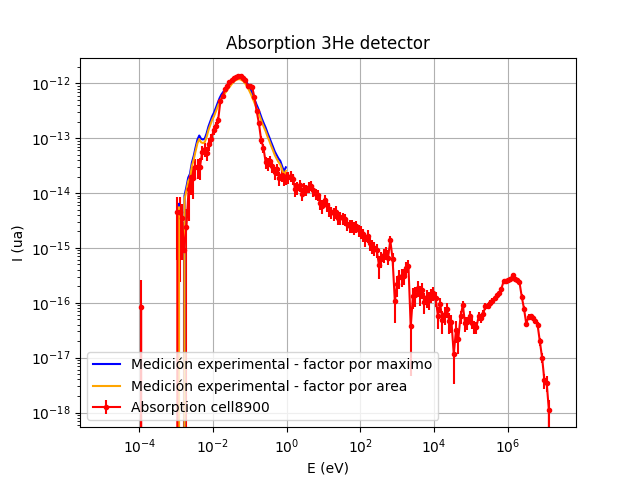

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openmc

espectro = (
    "/home/lucas/Documents/Proyecto_Integrador/PI/conductoN5/procesamiento/espectro.DAT"
)

sp = []
sp_N = []

sp1 = "/home/lucas/Documents/Proyecto_Integrador/PI/conductoN5/medicion1e9/statepoint.1000.h5"
sp.append(sp1)
sp1_N = 1000
sp_N.append(sp1_N)

sp2 = "/home/lucas/Documents/Proyecto_Integrador/PI/conductoN5/medicion1e9_2/statepoint.1000.h5"
sp.append(sp2)
sp2_N = 1000
sp_N.append(sp2_N)

sp3 = "/home/lucas/Documents/Proyecto_Integrador/PI/conductoN5/medicion5e8/statepoint.500.h5"
sp.append(sp3)
sp3_N = 500
sp_N.append(sp3_N)

sp4 = "/home/lucas/Documents/Proyecto_Integrador/PI/conductoN5/medicion5e8_2/statepoint.500.h5"
sp.append(sp4)
sp4_N = 500
sp_N.append(sp4_N)

sp5 = "/home/lucas/Documents/Proyecto_Integrador/PI/conductoN5/medicion8e8/statepoint.800.h5"
sp.append(sp5)
sp5_N = 800
sp_N.append(sp5_N)

sp6 = "/home/lucas/Documents/Proyecto_Integrador/PI/conductoN5/medicion1e9_3/statepoint.1200.h5"
sp.append(sp6)
sp6_N = 1200
sp_N.append(sp6_N)


def combinar_statepoints(sp_list, sp_N_list, tally_name="detector_neutron"):
    dfs = []
    for sp_path, n_batches in zip(sp_list, sp_N_list):
        with openmc.StatePoint(sp_path) as sp:
            tally = sp.get_tally(name=tally_name)
            df = tally.get_pandas_dataframe(nuclides=False)
            df = df[
                [
                    "energy low [eV]",
                    "energy high [eV]",
                    "cell",
                    "particle",
                    "score",
                    "mean",
                    "std. dev.",
                ]
            ].copy()
            df.columns = ["Emin", "Emax", "cell", "particle", "score", "mean", "stdv"]
            df["mean"] *= n_batches
            df["stdv2"] = (df["stdv"] ** 2) * n_batches
            dfs.append(df)

    # Sumar todos los dataframes
    df_sum = dfs[0][["Emin", "Emax", "cell", "particle", "score"]].copy()
    df_sum["mean"] = 0
    df_sum["stdv2"] = 0

    for df in dfs:
        df_sum["mean"] += df["mean"]
        df_sum["stdv2"] += df["stdv2"]

    total_batches = sum(sp_N_list)
    df_sum["mean"] /= total_batches
    df_sum["stdv"] = np.sqrt(df_sum["stdv2"] / total_batches)
    df_sum = df_sum.drop(columns=["stdv2"])

    return df_sum


df = combinar_statepoints(sp, sp_N)


def calcular_factor_normalizacion(df_tally, df_measured):
    """
    Calcula un factor de normalización entre dos espectros dados:
    - df_tally: espectro simulado (con columnas 'Emin', 'Emax', 'mean')
    - df_measured: espectro medido (con columnas 'Emed', 'mean')

    Returns:
        float: factor de normalización (area_tally / area_measured)
    """
    # --- Intervalo común ---
    Emin_common = df_measured["E_eV"].min()
    Emax_common = df_measured["E_eV"].max()

    # Filtrar al intervalo común
    df_tally_common = df_tally[
        (df_tally["Emin"] >= Emin_common) & (df_tally["Emax"] <= Emax_common)
    ].copy()
    df_measured_common = df_measured[
        (df_measured["E_eV"] >= Emin_common) & (df_measured["E_eV"] <= Emax_common)
    ].copy()

    # --- Área del espectro tally ---
    df_tally_common["delta_E"] = df_tally_common["Emax"] - df_tally_common["Emin"]
    area_tally = (df_tally_common["delta_E"] * df_tally_common["mean"]).sum()

    # --- Área del espectro medido ---
    emed_vals = df_measured_common["E_eV"].values
    mean_vals = df_measured_common["ESP"].values

    # Estimar bordes de energía
    E_edges = np.zeros(len(emed_vals) + 1)
    E_edges[1:-1] = (emed_vals[1:] + emed_vals[:-1]) / 2
    E_edges[0] = emed_vals[0] - (E_edges[1] - emed_vals[0])
    E_edges[-1] = emed_vals[-1] + (emed_vals[-1] - E_edges[-2])

    # Calcular ancho de bin
    delta_E = np.diff(E_edges)

    # Calcular área
    area_measured = np.sum(delta_E * mean_vals)

    # Factor de normalización
    factor = area_tally / area_measured

    return factor


df_exp = pd.read_csv(
    espectro,
    delim_whitespace=True,
    comment="@",
    skiprows=3,
    skipfooter=3,  # Salta las últimas 3 filas
    header=None,
    names=["E_meV", "ESP", "ERR", "CANI", "CANS", "DCAN"],
    engine="python",
)
df_exp["E_eV"] = df_exp["E_meV"] / 1e3
factor = calcular_factor_normalizacion(df, df_exp)

def comprimir_energia(df, centro, factor, columna="E_eV"):
    """
    Comprime los valores de la columna de energía respecto a un centro y un factor.
    Args:
        df (pd.DataFrame): DataFrame con la columna de energía.
        centro (float): Valor central que no se mueve.
        factor (float): Factor de compresión (<1 comprime, >1 expande).
        columna (str): Nombre de la columna de energía.
    Returns:
        pd.DataFrame: DataFrame con la columna de energía comprimida.
    """
    df = df.copy()
    df[columna] = centro + (df[columna] - centro) * factor
    return df

# df_exp = comprimir_energia(df_exp, 0.05, 0.97)

%matplotlib widget

plt.figure()
# df.plot(
#     x="Emin", y="mean", style="r.-", logx=True, logy=False, label="Absorption cell8900"
# )  # , ylim=[1E-10,10e0]
plt.errorbar(
    df["Emin"],           # eje x
    df["mean"],           # eje y
    yerr=df["stdv"],      # barras de error
    fmt="r.-",            # formato de puntos y líneas
    label="Absorption cell8900"
)
plt.plot(
    df_exp["E_eV"],
    df_exp["ESP"] * 4.533e-12,
    "b-",
    label="Medición experimental - factor por maximo",
)  # , ylim=[1E-10,10e0]
plt.plot(
    df_exp["E_eV"],
    -df_exp["ESP"] * factor,
    "orange",
    label="Medición experimental - factor por area",
)  # , ylim=[1E-10,10e0]
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.title("Absorption 3He detector")
plt.xlabel("E (eV)")
plt.ylabel("I (ua)")
plt.grid(True)
plt.show()

## ploteo abosrcion corregido


/tmp/ipykernel_76598/3814131482.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_exp = pd.read_csv(


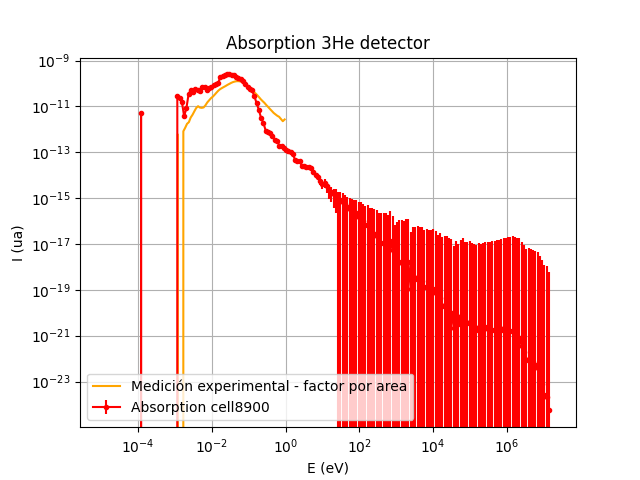

In [2]:
df = combinar_statepoints(sp, sp_N)
df["mean"] = df["mean"] /((df["Emax"] - df["Emin"]))


df_exp = pd.read_csv(
    espectro,
    delim_whitespace=True,
    comment="@",
    skiprows=3,
    skipfooter=3,  # Salta las últimas 3 filas
    header=None,
    names=["E_meV", "ESP", "ERR", "CANI", "CANS", "DCAN"],
    engine="python",
)
df_exp["E_eV"] = df_exp["E_meV"] / 1e3
factor = calcular_factor_normalizacion(df, df_exp)


%matplotlib widget

plt.figure()
# df.plot(
#     x="Emin", y="mean", style="r.-", logx=True, logy=False, label="Absorption cell8900"
# )  # , ylim=[1E-10,10e0]
plt.errorbar(
    (df["Emin"]+df["Emax"])/2,          # eje x
    df["mean"],           # eje y
    yerr=df["stdv"],      # barras de error
    fmt="r.-",            # formato de puntos y líneas
    label="Absorption cell8900"
)
# plt.plot(
#     df_exp["E_eV"],
#     df_exp["ESP"] * 4.533e-12,
#     "b-",
#     label="Medición experimental - factor por maximo",
# )  # , ylim=[1E-10,10e0]
plt.plot(
    df_exp["E_eV"],
    -df_exp["ESP"] * factor,
    "orange",
    label="Medición experimental - factor por area",
)  # , ylim=[1E-10,10e0]
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.title("Absorption 3He detector")
plt.xlabel("E (eV)")
plt.ylabel("I (ua)")
plt.grid(True)
plt.show()

## ploteo flujo

/tmp/ipykernel_76598/2081695647.py:132: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_exp = pd.read_csv(


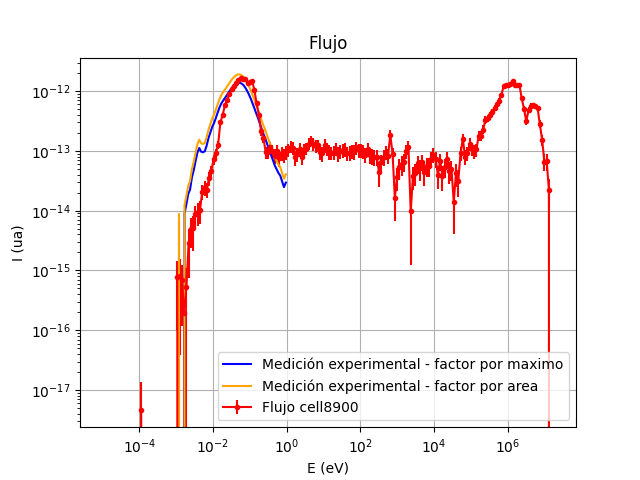

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openmc

espectro = (
    "/home/lucas/Documents/Proyecto_Integrador/PI/conductoN5/procesamiento/espectro.DAT"
)

sp = []
sp_N = []

sp1 = "/home/lucas/Documents/Proyecto_Integrador/PI/conductoN5/medicion1e9/statepoint.1000.h5"
sp.append(sp1)
sp1_N = 1000
sp_N.append(sp1_N)

sp2 = "/home/lucas/Documents/Proyecto_Integrador/PI/conductoN5/medicion1e9_2/statepoint.1000.h5"
sp.append(sp2)
sp2_N = 1000
sp_N.append(sp2_N)

sp3 = "/home/lucas/Documents/Proyecto_Integrador/PI/conductoN5/medicion5e8/statepoint.500.h5"
sp.append(sp3)
sp3_N = 500
sp_N.append(sp3_N)

sp4 = "/home/lucas/Documents/Proyecto_Integrador/PI/conductoN5/medicion5e8_2/statepoint.500.h5"
sp.append(sp4)
sp4_N = 500
sp_N.append(sp4_N)

sp5 = "/home/lucas/Documents/Proyecto_Integrador/PI/conductoN5/medicion8e8/statepoint.800.h5"
sp.append(sp5)
sp5_N = 800
sp_N.append(sp5_N)

sp6 = "/home/lucas/Documents/Proyecto_Integrador/PI/conductoN5/medicion1e9_3/statepoint.1200.h5"
sp.append(sp6)
sp6_N = 1200
sp_N.append(sp6_N)

def combinar_statepoints(sp_list, sp_N_list, tally_name="detector_neutron_flux"):
    dfs = []
    for sp_path, n_batches in zip(sp_list, sp_N_list):
        with openmc.StatePoint(sp_path) as sp:
            tally = sp.get_tally(name=tally_name)
            df = tally.get_pandas_dataframe(nuclides=False)
            df = df[
                [
                    "energy low [eV]",
                    "energy high [eV]",
                    "cell",
                    "particle",
                    "score",
                    "mean",
                    "std. dev.",
                ]
            ].copy()
            df.columns = ["Emin", "Emax", "cell", "particle", "score", "mean", "stdv"]
            df["mean"] *= n_batches
            df["stdv2"] = (df["stdv"] ** 2) * n_batches
            dfs.append(df)

    # Sumar todos los dataframes
    df_sum = dfs[0][["Emin", "Emax", "cell", "particle", "score"]].copy()
    df_sum["mean"] = 0
    df_sum["stdv2"] = 0

    for df in dfs:
        df_sum["mean"] += df["mean"]
        df_sum["stdv2"] += df["stdv2"]

    total_batches = sum(sp_N_list)
    df_sum["mean"] /= total_batches
    df_sum["stdv"] = np.sqrt(df_sum["stdv2"] / total_batches)
    df_sum = df_sum.drop(columns=["stdv2"])

    return df_sum


df = combinar_statepoints(sp, sp_N)


def calcular_factor_normalizacion(df_tally, df_measured):
    """
    Calcula un factor de normalización entre dos espectros dados:
    - df_tally: espectro simulado (con columnas 'Emin', 'Emax', 'mean')
    - df_measured: espectro medido (con columnas 'Emed', 'mean')

    Returns:
        float: factor de normalización (area_tally / area_measured)
    """
    # --- Intervalo común ---
    Emin_common = df_measured["E_eV"].min()
    Emax_common = df_measured["E_eV"].max()

    # Filtrar al intervalo común
    df_tally_common = df_tally[
        (df_tally["Emin"] >= Emin_common) & (df_tally["Emax"] <= Emax_common)
    ].copy()
    df_measured_common = df_measured[
        (df_measured["E_eV"] >= Emin_common) & (df_measured["E_eV"] <= Emax_common)
    ].copy()

    # --- Área del espectro tally ---
    df_tally_common["delta_E"] = df_tally_common["Emax"] - df_tally_common["Emin"]
    area_tally = (df_tally_common["delta_E"] * df_tally_common["mean"]).sum()

    # --- Área del espectro medido ---
    emed_vals = df_measured_common["E_eV"].values
    mean_vals = df_measured_common["ESP"].values

    # Estimar bordes de energía
    E_edges = np.zeros(len(emed_vals) + 1)
    E_edges[1:-1] = (emed_vals[1:] + emed_vals[:-1]) / 2
    E_edges[0] = emed_vals[0] - (E_edges[1] - emed_vals[0])
    E_edges[-1] = emed_vals[-1] + (emed_vals[-1] - E_edges[-2])

    # Calcular ancho de bin
    delta_E = np.diff(E_edges)

    # Calcular área
    area_measured = np.sum(delta_E * mean_vals)

    # Factor de normalización
    factor = area_tally / area_measured

    return factor


df_exp = pd.read_csv(
    espectro,
    delim_whitespace=True,
    comment="@",
    skiprows=3,
    skipfooter=3,  # Salta las últimas 3 filas
    header=None,
    names=["E_meV", "ESP", "ERR", "CANI", "CANS", "DCAN"],
    engine="python",
)
df_exp["E_eV"] = df_exp["E_meV"] / 1e3
factor = calcular_factor_normalizacion(df, df_exp)

%matplotlib widget

plt.figure()
plt.errorbar(
    df["Emin"],           # eje x
    df["mean"],           # eje y
    yerr=df["stdv"],      # barras de error
    fmt="r.-",            # formato de puntos y líneas
    label="Flujo cell8900"
)
# df.plot(
#     x="Emin", y="mean", style="r.-", logx=True, logy=False, label="Absorption cell8900"
# )  # , ylim=[1E-10,10e0]
plt.plot(
    df_exp["E_eV"],
    df_exp["ESP"] * 4.533e-12,
    "b-",
    label="Medición experimental - factor por maximo",
)  # , ylim=[1E-10,10e0]
plt.plot(
    df_exp["E_eV"],
    -df_exp["ESP"] * factor,
    "orange",
    label="Medición experimental - factor por area",
)  # , ylim=[1E-10,10e0]
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.title("Flujo")
plt.xlabel("E (eV)")
plt.ylabel("I (ua)")
plt.grid(True)
plt.show()

## ploteo e por flujo

/tmp/ipykernel_76598/101913112.py:132: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_exp = pd.read_csv(


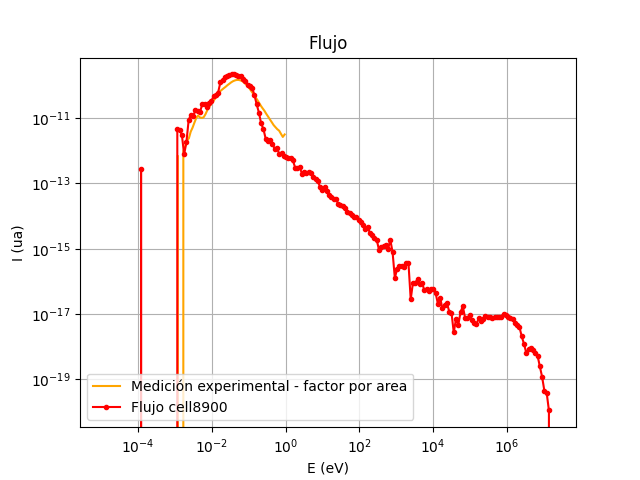

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openmc

espectro = (
    "/home/lucas/Documents/Proyecto_Integrador/PI/conductoN5/procesamiento/espectro.DAT"
)

sp = []
sp_N = []

sp1 = "/home/lucas/Documents/Proyecto_Integrador/PI/conductoN5/medicion1e9/statepoint.1000.h5"
sp.append(sp1)
sp1_N = 1000
sp_N.append(sp1_N)

sp2 = "/home/lucas/Documents/Proyecto_Integrador/PI/conductoN5/medicion1e9_2/statepoint.1000.h5"
sp.append(sp2)
sp2_N = 1000
sp_N.append(sp2_N)

sp3 = "/home/lucas/Documents/Proyecto_Integrador/PI/conductoN5/medicion5e8/statepoint.500.h5"
sp.append(sp3)
sp3_N = 500
sp_N.append(sp3_N)

sp4 = "/home/lucas/Documents/Proyecto_Integrador/PI/conductoN5/medicion5e8_2/statepoint.500.h5"
sp.append(sp4)
sp4_N = 500
sp_N.append(sp4_N)

sp5 = "/home/lucas/Documents/Proyecto_Integrador/PI/conductoN5/medicion8e8/statepoint.800.h5"
sp.append(sp5)
sp5_N = 800
sp_N.append(sp5_N)

sp6 = "/home/lucas/Documents/Proyecto_Integrador/PI/conductoN5/medicion1e9_3/statepoint.1200.h5"
sp.append(sp6)
sp6_N = 1200
sp_N.append(sp6_N)

def combinar_statepoints(sp_list, sp_N_list, tally_name="detector_neutron_flux"):
    dfs = []
    for sp_path, n_batches in zip(sp_list, sp_N_list):
        with openmc.StatePoint(sp_path) as sp:
            tally = sp.get_tally(name=tally_name)
            df = tally.get_pandas_dataframe(nuclides=False)
            df = df[
                [
                    "energy low [eV]",
                    "energy high [eV]",
                    "cell",
                    "particle",
                    "score",
                    "mean",
                    "std. dev.",
                ]
            ].copy()
            df.columns = ["Emin", "Emax", "cell", "particle", "score", "mean", "stdv"]
            df["mean"] *= n_batches
            df["stdv2"] = (df["stdv"] ** 2) * n_batches
            dfs.append(df)

    # Sumar todos los dataframes
    df_sum = dfs[0][["Emin", "Emax", "cell", "particle", "score"]].copy()
    df_sum["mean"] = 0
    df_sum["stdv2"] = 0

    for df in dfs:
        df_sum["mean"] += df["mean"]
        df_sum["stdv2"] += df["stdv2"]

    total_batches = sum(sp_N_list)
    df_sum["mean"] /= total_batches
    df_sum["stdv"] = np.sqrt(df_sum["stdv2"] / total_batches)
    df_sum = df_sum.drop(columns=["stdv2"])

    return df_sum


df = combinar_statepoints(sp, sp_N)


def calcular_factor_normalizacion(df_tally, df_measured):
    """
    Calcula un factor de normalización entre dos espectros dados:
    - df_tally: espectro simulado (con columnas 'Emin', 'Emax', 'mean')
    - df_measured: espectro medido (con columnas 'Emed', 'mean')

    Returns:
        float: factor de normalización (area_tally / area_measured)
    """
    # --- Intervalo común ---
    Emin_common = df_measured["E_eV"].min()
    Emax_common = df_measured["E_eV"].max()

    # Filtrar al intervalo común
    df_tally_common = df_tally[
        (df_tally["Emin"] >= Emin_common) & (df_tally["Emax"] <= Emax_common)
    ].copy()
    df_measured_common = df_measured[
        (df_measured["E_eV"] >= Emin_common) & (df_measured["E_eV"] <= Emax_common)
    ].copy()

    # --- Área del espectro tally ---
    df_tally_common["delta_E"] = df_tally_common["Emax"] - df_tally_common["Emin"]
    area_tally = (df_tally_common["delta_E"] * df_tally_common["mean"]).sum()

    # --- Área del espectro medido ---
    emed_vals = df_measured_common["E_eV"].values
    mean_vals = df_measured_common["ESP"].values

    # Estimar bordes de energía
    E_edges = np.zeros(len(emed_vals) + 1)
    E_edges[1:-1] = (emed_vals[1:] + emed_vals[:-1]) / 2
    E_edges[0] = emed_vals[0] - (E_edges[1] - emed_vals[0])
    E_edges[-1] = emed_vals[-1] + (emed_vals[-1] - E_edges[-2])

    # Calcular ancho de bin
    delta_E = np.diff(E_edges)

    # Calcular área
    area_measured = np.sum(delta_E * mean_vals)

    # Factor de normalización
    factor = area_tally / area_measured

    return factor


df_exp = pd.read_csv(
    espectro,
    delim_whitespace=True,
    comment="@",
    skiprows=3,
    skipfooter=3,  # Salta las últimas 3 filas
    header=None,
    names=["E_meV", "ESP", "ERR", "CANI", "CANS", "DCAN"],
    engine="python",
)
df_exp["E_eV"] = df_exp["E_meV"] / 1e3
df["mean"] = df["mean"] /((df["Emax"] - df["Emin"]))
factor = calcular_factor_normalizacion(df, df_exp)

%matplotlib widget

plt.figure()
plt.errorbar(
    (df["Emin"]+df["Emax"])/2,           # eje x
    df["mean"],           # eje y
    # yerr=df["stdv"],      # barras de error
    fmt="r.-",            # formato de puntos y líneas
    label="Flujo cell8900"
)
# df.plot(
#     x="Emin", y="mean", style="r.-", logx=True, logy=False, label="Absorption cell8900"
# )  # , ylim=[1E-10,10e0]
# plt.plot(
#     df_exp["E_eV"],
#     df_exp["ESP"] * 4.533e-12,
#     "b-",
#     label="Medición experimental - factor por maximo",
# )  # , ylim=[1E-10,10e0]
plt.plot(
    df_exp["E_eV"],
    -df_exp["ESP"] * factor,
    "orange",
    label="Medición experimental - factor por area",
)  # , ylim=[1E-10,10e0]
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.title("Flujo")
plt.xlabel("E (eV)")
plt.ylabel("I (ua)")
plt.grid(True)
plt.show()

In [5]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import openmc

# espectro = (
#     "/home/lucas/Documents/Proyecto_Integrador/PI/conductoN5/procesamiento/espectro.DAT"
# )

# sp = []
# sp_N = []

# sp1 = "/home/lucas/Documents/Proyecto_Integrador/PI/conductoN5/medicion1e9/statepoint.1000.h5"
# sp.append(sp1)
# sp1_N = 1000
# sp_N.append(sp1_N)

# sp2 = "/home/lucas/Documents/Proyecto_Integrador/PI/conductoN5/medicion1e9_2/statepoint.1000.h5"
# sp.append(sp2)
# sp2_N = 1000
# sp_N.append(sp2_N)

# sp3 = "/home/lucas/Documents/Proyecto_Integrador/PI/conductoN5/medicion5e8/statepoint.500.h5"
# sp.append(sp3)
# sp3_N = 500
# sp_N.append(sp3_N)

# sp4 = "/home/lucas/Documents/Proyecto_Integrador/PI/conductoN5/medicion5e8_2/statepoint.500.h5"
# sp.append(sp4)
# sp4_N = 500
# sp_N.append(sp4_N)

# sp5 = "/home/lucas/Documents/Proyecto_Integrador/PI/conductoN5/medicion8e8/statepoint.800.h5"
# sp.append(sp5)
# sp5_N = 800
# sp_N.append(sp5_N)

# sp6 = "/home/lucas/Documents/Proyecto_Integrador/PI/conductoN5/medicion1e9_3/statepoint.1200.h5"
# sp.append(sp6)
# sp6_N = 1200
# sp_N.append(sp6_N)

# def combinar_statepoints(sp_list, sp_N_list, tally_name="spectra_neutron"):
#     dfs = []
#     for sp_path, n_batches in zip(sp_list, sp_N_list):
#         with openmc.StatePoint(sp_path) as sp:
#             tally = sp.get_tally(name=tally_name)
#             df = tally.get_pandas_dataframe(nuclides=False)
#             df.columns = [
#                 "Emin",
#                 "Emax",
#                 "x",
#                 "y",
#                 "z",
#                 "surf",
#                 "particle",
#                 "score",
#                 "mean",
#                 "stdv",
#             ]
#             df["mean"] *= n_batches
#             df["stdv2"] = (df["stdv"] ** 2) * n_batches
#             dfs.append(df)

#     # Sumar todos los dataframes
#     df_sum = dfs[0][["Emin", "Emax", "cell", "particle", "score"]].copy()
#     df_sum["mean"] = 0
#     df_sum["stdv2"] = 0

#     for df in dfs:
#         df_sum["mean"] += df["mean"]
#         df_sum["stdv2"] += df["stdv2"]

#     total_batches = sum(sp_N_list)
#     df_sum["mean"] /= total_batches
#     df_sum["stdv"] = np.sqrt(df_sum["stdv2"] / total_batches)
#     df_sum = df_sum.drop(columns=["stdv2"])

#     return df_sum


# df = combinar_statepoints(sp, sp_N)


# def calcular_factor_normalizacion(df_tally, df_measured):
#     """
#     Calcula un factor de normalización entre dos espectros dados:
#     - df_tally: espectro simulado (con columnas 'Emin', 'Emax', 'mean')
#     - df_measured: espectro medido (con columnas 'Emed', 'mean')

#     Returns:
#         float: factor de normalización (area_tally / area_measured)
#     """
#     # --- Intervalo común ---
#     Emin_common = df_measured["E_eV"].min()
#     Emax_common = df_measured["E_eV"].max()

#     # Filtrar al intervalo común
#     df_tally_common = df_tally[
#         (df_tally["Emin"] >= Emin_common) & (df_tally["Emax"] <= Emax_common)
#     ].copy()
#     df_measured_common = df_measured[
#         (df_measured["E_eV"] >= Emin_common) & (df_measured["E_eV"] <= Emax_common)
#     ].copy()

#     # --- Área del espectro tally ---
#     df_tally_common["delta_E"] = df_tally_common["Emax"] - df_tally_common["Emin"]
#     area_tally = (df_tally_common["delta_E"] * df_tally_common["mean"]).sum()

#     # --- Área del espectro medido ---
#     emed_vals = df_measured_common["E_eV"].values
#     mean_vals = df_measured_common["ESP"].values

#     # Estimar bordes de energía
#     E_edges = np.zeros(len(emed_vals) + 1)
#     E_edges[1:-1] = (emed_vals[1:] + emed_vals[:-1]) / 2
#     E_edges[0] = emed_vals[0] - (E_edges[1] - emed_vals[0])
#     E_edges[-1] = emed_vals[-1] + (emed_vals[-1] - E_edges[-2])

#     # Calcular ancho de bin
#     delta_E = np.diff(E_edges)

#     # Calcular área
#     area_measured = np.sum(delta_E * mean_vals)

#     # Factor de normalización
#     factor = area_tally / area_measured

#     return factor


# df_exp = pd.read_csv(
#     espectro,
#     delim_whitespace=True,
#     comment="@",
#     skiprows=3,
#     skipfooter=3,  # Salta las últimas 3 filas
#     header=None,
#     names=["E_meV", "ESP", "ERR", "CANI", "CANS", "DCAN"],
#     engine="python",
# )
# df_exp["E_eV"] = df_exp["E_meV"] / 1e3
# factor = calcular_factor_normalizacion(df, df_exp)

# %matplotlib widget

# plt.figure()
# plt.errorbar(
#     df["Emin"],           # eje x
#     df["mean"],           # eje y
#     yerr=df["stdv"],      # barras de error
#     fmt="r.-",            # formato de puntos y líneas
#     label="Flujo cell8900"
# )
# # df.plot(
# #     x="Emin", y="mean", style="r.-", logx=True, logy=False, label="Absorption cell8900"
# # )  # , ylim=[1E-10,10e0]
# plt.plot(
#     df_exp["E_eV"],
#     df_exp["ESP"] * 4.533e-12,
#     "b-",
#     label="Medición experimental - factor por maximo",
# )  # , ylim=[1E-10,10e0]
# plt.plot(
#     df_exp["E_eV"],
#     -df_exp["ESP"] * factor,
#     "orange",
#     label="Medición experimental - factor por area",
# )  # , ylim=[1E-10,10e0]
# plt.legend()
# plt.yscale("log")
# plt.xscale("log")
# plt.title("Flujo")
# plt.xlabel("E (eV)")
# plt.ylabel("I (ua)")
# plt.grid(True)
# plt.show()